In [13]:
import os
import glob
import warnings
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


# import shapely
import cartopy as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

import geopandas as gpd
import shapely
from tqdm import tqdm

In [14]:
# configure data path

current_path = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(current_path, "..", "data")

data_path = os.path.normpath(data_path)

In [15]:
print(data_path)

/media/dk/New Volume/space_weather_econ/data


In [16]:
# Read Greg's year event data

# event_100_year = pd.read_csv(os.path.join(data_path, "geoelectric_100year.csv"))
# event_100_year.head()

### Statistics of US Businesses (Employments and State GDPs)

In [17]:
def read_text_file(file):
    """This custom function reads large text/csv 
    files, especially those with encoding errors due
    to compression
    
    """
    # check if tuple
    file_path = os.path.join(data_path, file) if isinstance(file, str) else os.path.join(data_path, *file)
        
    with open(file_path,encoding='utf-8', errors='ignore') as file:
        content = file.read()

    content_io = StringIO(content)
    return pd.read_csv(content_io, low_memory=False)


In [18]:
# load GDP data
gdp_state = read_text_file(("SAGDP", "SAGDP1__ALL_AREAS_2017_2022.csv"))

# use gdp data (millions of chained 2017 dollars dollars)
state_2022 = gdp_state[gdp_state.Description == "Real GDP (millions of chained 2017 dollars) 1/"]
state_2022.loc[:, "STATE"]  = state_2022.GeoFIPS.apply(lambda fips: int(fips[2:4]))

# load the NAICS data
with open(os.path.join(data_path, "us_state_naics_detailedsizes_2020.txt"), encoding='utf-8', errors='ignore') as file:
    content = file.read()

content_io = StringIO(content)

us_states_details_naics = pd.read_csv(content_io)

# extract the total employments in each entersize per state

state_empl = us_states_details_naics[(us_states_details_naics.ENTRSIZE == 1) & (us_states_details_naics.NAICSDSCR == "Total")]
state_empl_reset = state_empl.reset_index(drop=True)

# load the 2020 state population data
pop_data = pd.read_csv(os.path.join(data_path, "pop_2020_state.csv"))

# join the three datasets
state_gdp_empl_pop = state_empl_reset.merge(state_2022[["2022", "STATE"]], on="STATE").merge(pop_data, on="STATE")
state_gdp_empl_pop.rename(columns = {"2022": "2022REALGDP", "POPULATION": "STPOP", "stab": "STABBR"}, inplace=True)
state_gdp_empl_pop.drop("STATE", axis=1, inplace=True)


# free some memory

del gdp_state
del state_empl 
# del us_states_details_naics 
del content_io
del state_empl_reset
del state_2022

state_gdp_empl_pop.head(5)

/tmp/ipykernel_17018/602719734.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_2022.loc[:, "STATE"]  = state_2022.GeoFIPS.apply(lambda fips: int(fips[2:4]))


,NAICS,ENTRSIZE,FIRM,ESTB,EMPL,EMPLFL_N,PAYR,PAYRFL_N,STATEDSCR,NAICSDSCR,ENTRSIZEDSCR,2022REALGDP,STABBR,STPOP
0,--,1,74850,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,AL,5024279
1,--,1,17169,21184,266063,G,16331033,G,Alaska,Total,01: Total,50315.1,AK,733391
2,--,1,116423,149829,2644781,G,134085208,G,Arizona,Total,01: Total,403474.2,AZ,7151502
3,--,1,51451,67586,1055534,G,47494746,G,Arkansas,Total,01: Total,137355.5,AR,3011524
4,--,1,805423,981369,15710859,G,1132425660,G,California,Total,01: Total,3167460.8,CA,39538223


### US. Electricity Transmission Operators

In [81]:
# Load your shapefile into a GeoDataFrame
rto_gdf = gpd.read_file(os.path.join(data_path, "NERC Map", "electricity_operators.shp"))

# Check for overlaps by performing a spatial join with itself
overlaps = gpd.sjoin(rto_gdf, rto_gdf, how='inner', predicate='intersects')
overlaps = overlaps[overlaps['id_left'] != overlaps['id_right']]

nerc_gdf = rto_gdf.copy()

# Subtract the geometries of overlapping inner polygons from their outer polygons
for _, row in overlaps.iterrows():
    outer_geom = nerc_gdf.loc[nerc_gdf['id'] == row['id_left'], 'geometry'].iloc[0]
    inner_geom = nerc_gdf.loc[nerc_gdf['id'] == row['id_right'], 'geometry'].iloc[0]
    if inner_geom.within(outer_geom):
        nerc_gdf.loc[nerc_gdf['id'] == row['id_left'], 'geometry'] = outer_geom.difference(inner_geom)

nerc_gdf.to_crs(epsg=4326, inplace=True)

# fix the outer boundaries of the NERC df by clipping with state boundaries from USPS
# state boundaries
states = gpd.read_file(os.path.join(data_path, "tl_2022_us_state.zip"))
states.to_crs(epsg=4326, inplace=True)

# non contig states
non_cont_fips_codes = ['02', '15', '72', '66', '60', '69', '78', '78']
states = states[~states.GEOID.isin(non_cont_fips_codes)]


# rename column id to REGION_ID
nerc_gdf.rename(columns={"id": "REGION_ID"}, inplace=True)
nerc_gdf.loc[nerc_gdf['REGION_ID'] == 23, 'REGIONS'] = 'ERCOT'

In [82]:
# fix the alignment of the digitized raster
utm_epsg_code = 32633
nerc_gdf_projected = nerc_gdf.to_crs(epsg=utm_epsg_code)
states_projected = states.to_crs(epsg=utm_epsg_code)

# apply buffer of 10 metres
buffer_distance = 10
nerc_gdf_buffered = nerc_gdf_projected.buffer(buffer_distance)

# create a single polygon
states_boundary = states_projected.geometry.unary_union

# make sure the coordinate systems are equal
states_boundary_gdf = gpd.GeoDataFrame(geometry=[states_boundary], crs=utm_epsg_code)

# overlay the two
aligned_nerc = gpd.overlay(gpd.GeoDataFrame(geometry=nerc_gdf_buffered, crs=utm_epsg_code), 
                           states_boundary_gdf, 
                           how='intersection')

# reproject to the previous crs
aligned_nerc = aligned_nerc.to_crs(nerc_gdf.crs)

# Update the geometry
nerc_gdf.geometry = aligned_nerc.geometry

# write nerc into a geojson file
path = os.path.join(data_path, "nerc_gdf.geojson")
nerc_gdf.to_file(path, driver="GeoJSON")

### US Population at Census Block Levels

In [21]:
def format_tractce(tract):
    # add leading zeros if whole != 4 digits and trailing zero if decimal not 2 digits
    
    if type(tract) != str:
        whole, decimal = str(tract).split('.')
        # Add leading zeros to the whole number part if necessary to make it 4 digits
        whole = whole.zfill(4)
        if len(decimal) == 1:  # Check if decimal part is a single digit
            decimal += '0'  # Append a zero
        
        tract = f"{whole}.{decimal}"
    if type(tract) != str:
        print(tract)
    return tract.replace(".", "")

In [22]:
# load the data at block group levels

pop_bg = read_text_file("pop_2020_censu_block.csv")
pop_bg.drop(0, inplace=True)

pop_bg.rename(columns={"state":"STATEFP", "county":"COUNTYFP", "tract":"TRACTCE", "blockgroup":"BLKGRPCE", "pop20":"POP20BG", "afact":"AFACT", "stab": "STABBR"}, inplace=True)
pop_bg["TRACTCE"] = pop_bg.TRACTCE.apply(format_tractce)

# make thus columns string
cols_to_convert = ["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]
pop_bg[cols_to_convert] = pop_bg[cols_to_convert].astype(str)

pop_bg.STATEFP = pop_bg.STATEFP.astype(str)

# remove non contigous states 
pop_bg_cont = pop_bg[~pop_bg.STATEFP.isin(non_cont_fips_codes)]

# merge the population data at census block levels
block_gdp_pop = pop_bg_cont.merge(state_gdp_empl_pop, on="STABBR")
block_gdp_pop.POP20BG = block_gdp_pop.POP20BG.apply(lambda x: int(x))

# del pop_bg
# del pop_bg_cont
block_gdp_pop.head(5)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,STABBR,CountyName,POP20BG,AFACT,NAICS,ENTRSIZE,...,ESTB,EMPL,EMPLFL_N,PAYR,PAYRFL_N,STATEDSCR,NAICSDSCR,ENTRSIZEDSCR,2022REALGDP,STPOP
0,01,01001,020100,1,AL,Autauga AL,575,0.0001,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279
1,01,01001,020100,2,AL,Autauga AL,1200,0.0002,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279
2,01,01001,020200,1,AL,Autauga AL,974,0.0002,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279
3,01,01001,020200,2,AL,Autauga AL,1081,0.0002,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279
4,01,01001,020300,1,AL,Autauga AL,2377,0.0005,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279


### Census Block Group Shapefiles

In [11]:
directory = 'tl_bg'

file_pattern = 'tl_2020_*.zip'

# Get a list of all the shapefiles in the directory matching the pattern
output_shapefile_zip = 'combined_shapefile.zip'

if os.path.exists(os.path.join(data_path, output_shapefile_zip)):
    combined_gdf = gpd.read_file(os.path.join(data_path, output_shapefile_zip, "combined_shapefile.shp"))
else:
    shapefile_paths = glob.glob(os.path.join(data_path, directory, file_pattern))
    gdfs = [gpd.read_file(path) for path in shapefile_paths]
    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    del gdfs
    combined_gdf.to_file(os.path.join(data_path, output_shapefile_zip), driver='ESRI Shapefile')

In [12]:
# extract only contigous states census block gdf
cont_bg = combined_gdf[~combined_gdf.STATEFP.isin(non_cont_fips_codes)]

cont_bg["rep_points"] = cont_bg.geometry.representative_point()

# points/census blocks within NERD Transmission map
nerc_gdf = nerc_gdf.to_crs(cont_bg.crs)
points_within_rto = gpd.sjoin(cont_bg.set_geometry('rep_points'), nerc_gdf, how='inner', predicate='within')

# merge the census blocks and regional transmission op datasets
points_within_rto["COUNTYFP"] = points_within_rto["STATEFP"] + points_within_rto["COUNTYFP"]
points_within_rto[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]] = points_within_rto[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]].astype(str)

# join with the census and business stats data
df = points_within_rto.merge(block_gdp_pop, on=["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"])

df.head(5)

/home/dk/anaconda3/envs/spaceweather/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,ESTB,EMPL,EMPLFL_N,PAYR,PAYRFL_N,STATEDSCR,NAICSDSCR,ENTRSIZEDSCR,2022REALGDP,STPOP
0,20,20003,953600,3,200039536003,Block Group 3,G5030,S,1665923,4526,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880
1,20,20003,953600,4,200039536004,Block Group 4,G5030,S,4789695,76622,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880
2,20,20003,953600,1,200039536001,Block Group 1,G5030,S,329643568,2950927,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880
3,20,20003,953600,2,200039536002,Block Group 2,G5030,S,1688946,1498,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880
4,20,20003,953700,2,200039537002,Block Group 2,G5030,S,388883407,2399109,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880


In [13]:
# analysis dataframe in R
df["BGSTATEGDP"] = df.POP20BG/df.STPOP * df["2022REALGDP"]

df_analysis = df[["NAICS", "REGIONS", "STABBR", "POP20BG", 'FIRM', 'ESTB','EMPL', "REGION_ID", 'EMPLFL_N', 'PAYR', "NAICSDSCR", '2022REALGDP', 'STPOP', 'BGSTATEGDP']]

# save the df
df_analysis.to_csv(os.path.join(data_path, "df_rto_stats.csv"), index=False)

In [14]:
df.drop("rep_points", inplace=True, axis=1)

In [15]:
# save the dataframe as a GEOJSON
df.set_geometry("geometry", inplace=True)
df.to_crs(epsg=4326)

# path = os.path.join(data_path, "block_levels_gdf")
# df.to_file(path, driver="GeoJSON")

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,EMPL,EMPLFL_N,PAYR,PAYRFL_N,STATEDSCR,NAICSDSCR,ENTRSIZEDSCR,2022REALGDP,STPOP,BGSTATEGDP
0,20,20003,953600,3,200039536003,Block Group 3,G5030,S,1665923,4526,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,42.897227
1,20,20003,953600,4,200039536004,Block Group 4,G5030,S,4789695,76622,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,101.918101
2,20,20003,953600,1,200039536001,Block Group 1,G5030,S,329643568,2950927,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,108.938729
3,20,20003,953600,2,200039536002,Block Group 2,G5030,S,1688946,1498,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,40.814838
4,20,20003,953700,2,200039537002,Block Group 2,G5030,S,388883407,2399109,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,55.629553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234885,13,13039,010604,3,130390106043,Block Group 3,G5030,S,2367301,14498,...,4107151,G,216568398,G,Georgia,Total,01: Total,655827.3,10711908,90.917840
234886,13,13039,010604,2,130390106042,Block Group 2,G5030,S,1760863,131937,...,4107151,G,216568398,G,Georgia,Total,01: Total,655827.3,10711908,68.142462
234887,13,13039,010603,1,130390106031,Block Group 1,G5030,S,5708433,1349157,...,4107151,G,216568398,G,Georgia,Total,01: Total,655827.3,10711908,81.060755
234888,13,13039,010403,3,130390104033,Block Group 3,G5030,S,12222285,838590,...,4107151,G,216568398,G,Georgia,Total,01: Total,655827.3,10711908,83.142375


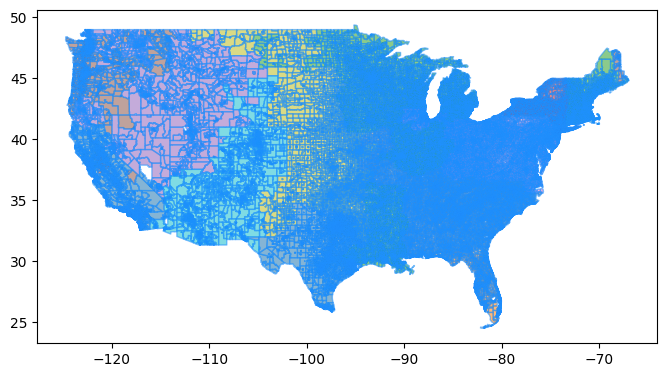

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (8, 10))

# Plot data
df.plot(ax=ax, column='REGIONS', edgecolor='dodgerblue', alpha=0.55, legend=False)

# Stylize plots
plt.style.use('bmh')

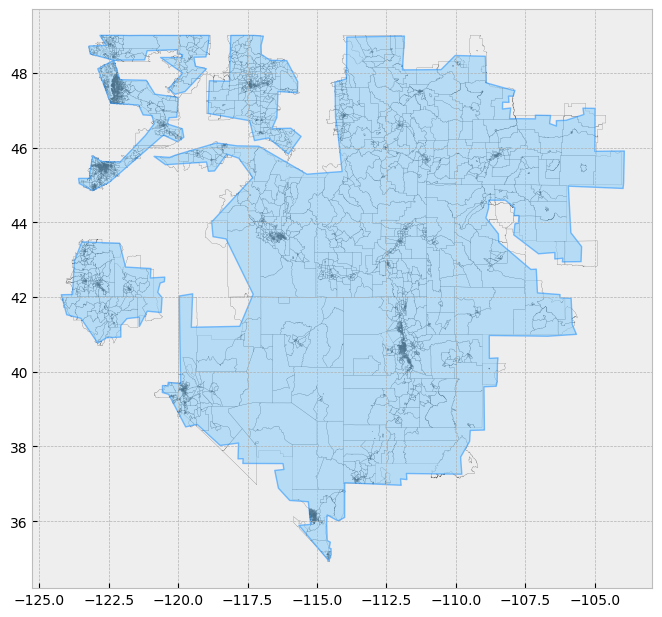

In [17]:
# Northern Grid and States

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 10))

nttg_gdf = df[df["REGIONS"] == "NorthernGridConnected"]

# nttg census blocks
nttg_raw = combined_gdf[combined_gdf.GEOID.isin(nttg_gdf.GEOID)]

# plot census blocks with slightly thin line
nttg_gdf.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor="none", column="POP20BG")

# plot rtos with thicker lines
nerc_gdf[nerc_gdf["REGIONS"] == "NorthernGridConnected"].plot(ax=ax, color='lightskyblue', edgecolor='dodgerblue', alpha=0.55, linewidth=1.0)

# Stylize plots
plt.style.use('bmh')

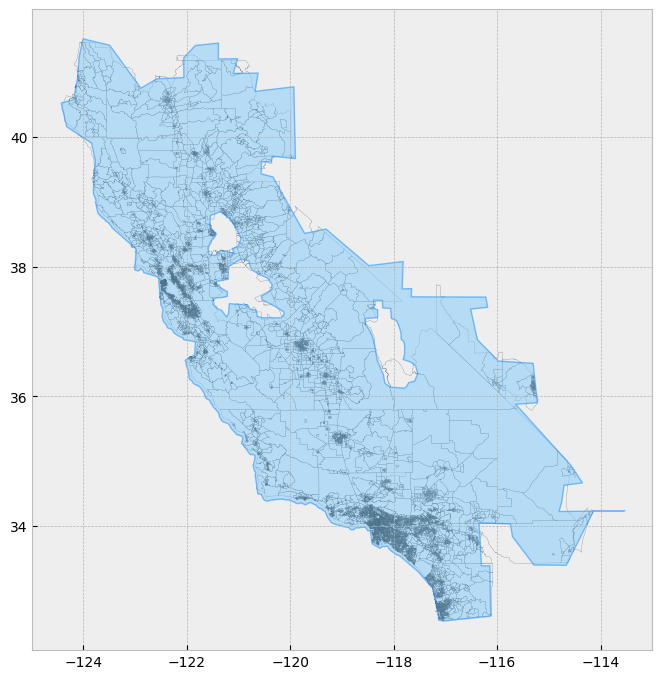

In [18]:
# CAISO and States

fig, ax = plt.subplots(1, 1, figsize = (8, 10))

caiso_gdf = df[df["REGIONS"] == "CAISO"]
# caiso_geometry_gdf = caiso_gdf.dissolve(by='REGIONS')

# caiso census blocks
caiso_raw = combined_gdf[combined_gdf.GEOID.isin(caiso_gdf.GEOID)]

# plot census blocks with slightly thin line
caiso_raw.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
nerc_gdf[nerc_gdf["REGIONS"] == "CAISO"].plot(ax=ax, color='lightskyblue', edgecolor='dodgerblue', alpha=0.55, linewidth=1.0)

# Stylize plots
plt.style.use('bmh')

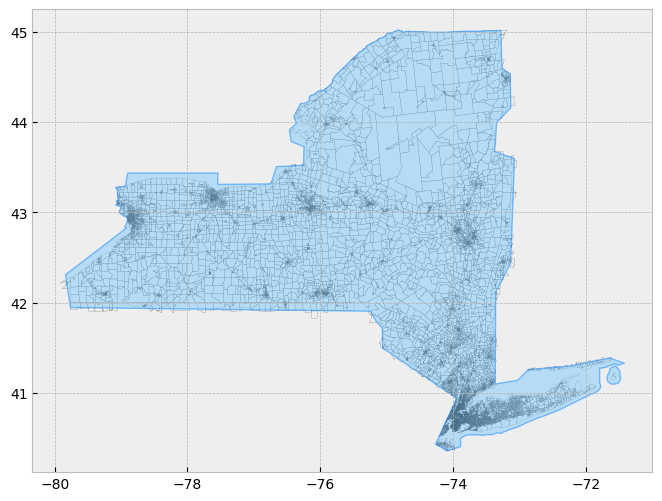

In [19]:
# NYISO and States

fig, ax = plt.subplots(1, 1, figsize = (8, 10))

nyiso_gdf = df[df["REGIONS"] == "NYISO"]

# nyisp census blocks
nyiso_raw = combined_gdf[combined_gdf.GEOID.isin(nyiso_gdf.GEOID)]

# plot census blocks with slightly thin line
nyiso_raw.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
nerc_gdf[nerc_gdf["REGIONS"] == "NYISO"].plot(ax=ax, color='lightskyblue', edgecolor='dodgerblue', alpha=0.55, linewidth=1.0)

# Stylize plots
plt.style.use('bmh')

## Business statistics at ZCTA levels

In [20]:
# read business data
# less detail zcta businesses data
zcta_cbp_total = read_text_file("zbp21totals.txt")
zcta_cbp_total.columns = [col.upper()for col in zcta_cbp_total.columns]
zcta_cbp_total.ZIP = zcta_cbp_total.ZIP.astype(int)

zcta_cbp_total.head(3)

,ZIP,NAME,EMP_NF,EMP,QP1_NF,QP1,AP_NF,AP,EST,CITY,STABBR,CTY_NAME
0,501,"HOLTSVILLE, NY",J,41,J,198,J,898,10,HOLTSVILLE,NY,SUFFOLK
1,1001,"AGAWAM, MA",G,7616,G,103920,G,447397,475,AGAWAM,MA,HAMPDEN
2,1002,"AMHERST, MA",H,7450,H,70191,H,315640,502,AMHERST,MA,HAMPSHIRE


In [21]:
# load the zcta shapefiles

zcta_gdf = gpd.read_file(os.path.join(data_path, "tl_2020_us_zcta520.zip"))
zcta_gdf.rename(columns={"ZCTA5CE20": "ZCTA"}, inplace=True)
zcta_gdf.ZCTA = zcta_gdf.ZCTA.astype(int)

# as a representative point
zcta_gdf['representative_point'] = zcta_gdf.geometry.representative_point()

In [22]:
# zctas within NERD Transmission map
nerc_gdf = nerc_gdf.to_crs(zcta_gdf.crs)

zcta_within_rto = gpd.sjoin(zcta_gdf.set_geometry('representative_point'), nerc_gdf, how='inner', predicate='within')

zcta_within_rto.columns = [col.upper()for col in zcta_within_rto.columns]
zcta_within_rto.head(3)

,ZCTA,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,GEOMETRY,REPRESENTATIVE_POINT,INDEX_RIGHT,REGION_ID,REGIONS
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.65390, -88.24713 33.654...",POINT (-88.08956 33.74089),20,21,SERTP
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582...",POINT (-87.98437 34.74181),20,21,SERTP
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.34960, -86.81649 34.349...",POINT (-86.73471 34.35011),20,21,SERTP


In [23]:
# load the population at the zcta level
zcta_pop_20 = read_text_file("pop_2020_zcta.csv")

# drop the first row
zcta_pop_20.drop(0, inplace=True)
zcta_pop_20.reset_index(inplace=True, drop=True)

zcta_pop_20["zcta"] = zcta_pop_20.zcta.str.strip()
zcta_pop_20 = zcta_pop_20[zcta_pop_20["zcta"] != ""]
zcta_pop_20[['zcta', "pop20"]] = zcta_pop_20[['zcta', "pop20"]].astype(int)

zcta_pop_20.columns = [col.upper()for col in zcta_pop_20.columns]
zcta_pop_20.rename(columns={"STAB": "STABBR"}, inplace=True)
zcta_pop_20.head(3)

,STATE,ZCTA,STABBR,ZIPNAME,POP20,AFACT
1,01,30165,AL,"Rome, GA",51,0
2,01,35004,AL,"Moody, AL",11477,0.0023
3,01,35005,AL,"Adamsville, AL",7578,0.0015


In [24]:
# read zcta zip concordance data

zcta_zip_df = pd.read_excel(os.path.join(data_path, "ZIPCodetoZCTACrosswalk2021UDS.xlsx"))
zz_not_na = zcta_zip_df[~zcta_zip_df.ZCTA.isna()]
zz_not_na.ZCTA = zz_not_na.ZCTA.astype(int)

zz_not_na.rename(columns={"ZIP_CODE":"ZIP", "STATE": "STABBR"}, inplace=True)
zz_not_na.head(3)

/tmp/ipykernel_11074/3968868041.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zz_not_na.ZCTA = zz_not_na.ZCTA.astype(int)
/tmp/ipykernel_11074/3968868041.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zz_not_na.rename(columns={"ZIP_CODE":"ZIP", "STATE": "STABBR"}, inplace=True)


,ZIP,PO_NAME,STABBR,ZIP_TYPE,ZCTA,zip_join_type
0,501,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
1,544,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
2,601,Adjuntas,PR,Zip Code Area,601,Zip matches ZCTA


In [25]:
# Add ZCTA column into the business data
# Sum the emplyoments, firms, and payrolls in each ZCTA

zz_df = zcta_cbp_total.merge(zz_not_na[["STABBR", "ZIP", "PO_NAME", "ZCTA"]], left_on=["ZIP", "STABBR"], right_on=["ZIP", "STABBR"])
zz_df_reset = zz_df.groupby(["ZCTA", "STABBR"])[["EMP", "QP1", "AP", "EST"]].sum().reset_index()

# add population data
zz_pop = zz_df_reset.merge(zcta_pop_20, on=["ZCTA", "STABBR"])

zz_pop.head()

,ZCTA,STABBR,EMP,QP1,AP,EST,STATE,ZIPNAME,POP20,AFACT
0,1001,MA,7616,103920,447397,475,25,"Agawam Town, MA",16984,0.0024
1,1002,MA,7616,71824,323244,514,25,"Amherst Center, MA",27558,0.0039
2,1003,MA,214,2166,9307,15,25,"Amherst Center, MA",13253,0.0019
3,1005,MA,818,7700,36543,99,25,"Barre, MA",4900,0.0007
4,1007,MA,1597,14330,66152,229,25,"Belchertown, MA",15423,0.0022


In [26]:
# merge the population, and business dataset with the zctas within rtos
df_zcta = zz_pop.merge(zcta_within_rto, on="ZCTA")

In [27]:
df_zcta.groupby("REGIONS")[["EMP", "EST", "POP20"]].sum().reset_index()

,REGIONS,EMP,EST,POP20
0,CAISO,12953016,930647,36669676
1,ERCOT,9363417,571573,25756383
2,FRCC,6979790,585058,20269759
3,ISONE,5779762,366502,14160438
4,MISO,16998586,1051362,44656227
5,NYISO,8097251,584840,21994860
6,NorthernGridConnected,6492293,463393,16095613
7,NorthernGridUnconnected,1227364,111484,4593872
8,NotOrder1000,769158,50776,2506448
9,PJM,25418712,1548042,65742117


In [28]:
df.groupby("REGIONS")[["POP20BG"]].sum().reset_index()

,REGIONS,POP20BG
0,CAISO,36592680
1,ERCOT,25771826
2,FRCC,20332393
3,ISONE,14155945
4,MISO,44732745
5,NYISO,22038595
6,NorthernGridConnected,16560671
7,NorthernGridUnconnected,4327744
8,NotOrder1000,2551988
9,PJM,66127547


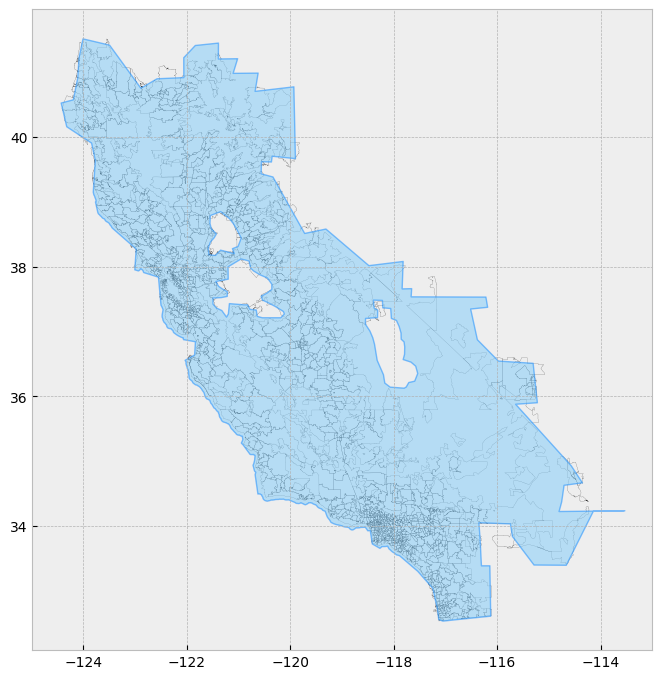

In [29]:
# CAISO and zctas

fig, ax = plt.subplots(1, 1, figsize = (8, 10))

caiso_gdf = df_zcta[df_zcta["REGIONS"] == "CAISO"]
# caiso_geometry_gdf = caiso_gdf.dissolve(by='REGIONS')

# caiso census blocks
caiso_raw = zcta_gdf[zcta_gdf.ZCTA.isin(caiso_gdf.ZCTA)]

# plot census blocks with slightly thin line
caiso_raw.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
nerc_gdf[nerc_gdf["REGIONS"] == "CAISO"].plot(ax=ax, color='lightskyblue', edgecolor='dodgerblue', alpha=0.55, linewidth=1.0)

# Stylize plots
plt.style.use('bmh')

In [30]:
# get the real gdp and state populations from the block level group df

# merge inner
df_zcta_gdp = df_zcta.merge(df[~df.duplicated(subset=["STABBR", "2022REALGDP"])][["STABBR", "2022REALGDP", "STPOP"]], on="STABBR")
df_zcta_gdp

,ZCTA,STABBR,EMP,QP1,AP,EST,STATE,ZIPNAME,POP20,AFACT,...,AWATER20,INTPTLAT20,INTPTLON20,GEOMETRY,REPRESENTATIVE_POINT,INDEX_RIGHT,REGION_ID,REGIONS,2022REALGDP,STPOP
0,1001,MA,7616,103920,447397,475,25,"Agawam Town, MA",16984,0.0024,...,2127894,+42.0623678,-072.6257536,"POLYGON ((-72.66788 42.04416, -72.66788 42.044...",POINT (-72.62353 42.06586),21,22,ISONE,604357.7,7029917
1,1002,MA,7616,71824,323244,514,25,"Amherst Center, MA",27558,0.0039,...,4280973,+42.3772116,-072.4647946,"POLYGON ((-72.54666 42.40131, -72.54656 42.402...",POINT (-72.46702 42.36982),21,22,ISONE,604357.7,7029917
2,1003,MA,214,2166,9307,15,25,"Amherst Center, MA",13253,0.0019,...,14001,+42.3918827,-072.5235844,"POLYGON ((-72.53340 42.38458, -72.53337 42.384...",POINT (-72.52482 42.38994),21,22,ISONE,604357.7,7029917
3,1005,MA,818,7700,36543,99,25,"Barre, MA",4900,0.0007,...,666424,+42.4188835,-072.1120769,"POLYGON ((-72.19734 42.42263, -72.19661 42.423...",POINT (-72.10540 42.41992),21,22,ISONE,604357.7,7029917
4,1007,MA,1597,14330,66152,229,25,"Belchertown, MA",15423,0.0022,...,6936467,+42.2839351,-072.4004088,"POLYGON ((-72.47202 42.35151, -72.47138 42.351...",POINT (-72.39828 42.27964),21,22,ISONE,604357.7,7029917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29888,99362,WA,15160,177976,805687,1191,53,"Walla Walla, WA",43184,0.0056,...,312780,+46.1010608,-118.3136249,"POLYGON ((-118.59649 46.21390, -118.59648 46.2...",POINT (-118.38792 46.10447),6,7,NorthernGridUnconnected,641143.6,7705281
29889,99363,WA,1993,29568,131342,17,53,"Wallula, WA",169,0,...,27476790,+46.0455687,-118.8852545,"POLYGON ((-118.98726 45.99985, -118.98452 46.0...",POINT (-118.89053 46.06235),6,7,NorthernGridUnconnected,641143.6,7705281
29890,99401,WA,3,14,105,3,53,"Anatone, WA",286,0,...,1075796,+46.0872068,-117.2498560,"POLYGON ((-117.47997 46.01631, -117.47991 46.0...",POINT (-117.21184 46.14901),6,7,NorthernGridUnconnected,641143.6,7705281
29891,99402,WA,141,1377,5869,30,53,"Asotin, WA",1814,0.0002,...,6816310,+46.2211438,-117.3512599,"POLYGON ((-117.42214 46.12195, -117.41948 46.1...",POINT (-117.31063 46.17386),6,7,NorthernGridUnconnected,641143.6,7705281


In [31]:
# calaculate the GDP based on the population

df_zcta_gdp["ZCTAGDP"] = df_zcta_gdp.POP20/df_zcta_gdp.STPOP * df_zcta_gdp["2022REALGDP"]

df_zcta_analysis = df_zcta_gdp[["STABBR", "EMP", "AP", "EST", "POP20","REGION_ID", "REGIONS", "2022REALGDP", "STPOP", "ZCTAGDP"]]

df_zcta_analysis.to_csv(os.path.join(data_path, "df_zcta.csv"), index=False)

### Electricity Transmission Lines Data

In [32]:
# Read Greg's year event data

event_100_year = pd.read_csv(os.path.join(data_path, "geoelectric_100year.csv"))
event_100_year.head()

,Site,longitude,latitude,B data max,B 100-year,E data max,E 100-year
0,ALW48,-87.017063,34.683700,586.341580,647.691181,0.632133,0.653597
1,ALW49,-86.182793,34.803785,612.239703,670.343795,0.177423,0.193047
2,ALX50,-85.497880,33.978540,624.223666,663.395479,1.053474,1.185257
3,ALY50,-85.884980,33.397383,618.895293,665.508524,4.002033,4.764058
4,ALZ51,-85.356061,32.801121,633.926421,673.093146,0.244623,0.280841


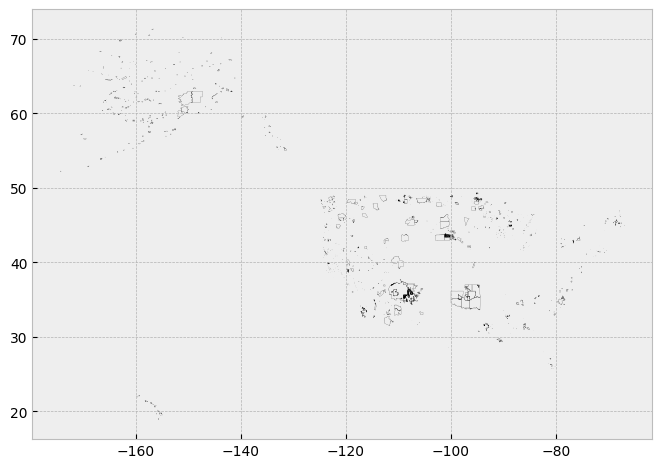

In [33]:
# transmission lines shapefiles

tl_gdf = gpd.read_file(os.path.join(data_path, "tl_2022_us_aiannh.zip"))

fig, ax = plt.subplots(1, 1, figsize = (8, 10))

tl_gdf.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor="none")

plt.show()